## Fonction to Raster
Prend en entrée une Satellite Image, un dossier et un nom et la sauve en JP2 dans le dossier considéré

In [1]:
! pip install pyarrow -q -q -q 
! pip install rasterio -q -q -q 
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q
! pip install albumentations -q -q -q
! pip install pytorch_lightning -q -q -q
!pip install mlflow -q -q -q

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from utils.satellite_image import SatelliteImage
from utils.utils import *
from utils.plot_utils import *

import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
#import cv2
from PIL import Image as im

from datetime import date
import re
import pyproj
import os
from tqdm import tqdm
from utils.labeler import RILLabeler
from utils.filter import is_too_black

In [2]:
root_path = get_root_path()
root_path

PosixPath('/home/onyxia/work/detection-habitat-spontane/notebooks/..')

In [3]:
update_storage_access()
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"][2022]["guyane"])

path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})


In [13]:
fs.download(
        rpath=f"{bucket}/{path_s3_cayenne_data}",
        lpath=f"{path_local_cayenne_data}",
        recursive=True)

In [4]:
def to_raster(satellite_image,directory_name,file_name):
    """
    save a SatelliteImage Object into a raster file (.tif)

    Args:
        satellite_image: a SatelliteImage object representing the input image to be saved as a raster file.
        directory_name: a string representing the name of the directory where the output file should be saved.
        file_name: a string representing the name of the output file.
    """

    data = satellite_image.array
    crs  = satellite_image.crs
    transform = satellite_image.transform
    n_bands = satellite_image.n_bands

    metadata = {
        'dtype': data.dtype,
        'count': n_bands,
        'width': data.shape[2],
        'height': data.shape[1],
        'crs': crs,
        'transform': transform
    }
    
    #print(os.path.exists(directory_name))
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Save the array as a raster file in jp2 format
    with rasterio.open(directory_name + "/" + file_name, 'w', **metadata) as dst:
        dst.write(data, indexes = np.arange(n_bands)+1)


def write_splitted_images_masks(file_path,output_directory_name,labeler,tile_size,n_bands, dep):
    
    """
    write the couple images mask into a specific folder

    Args:
        file_path: a string representing the path to the directory containing the input image files.
        output_directory_name: a string representing the name of the output directory where the split images and masks should be saved.
        labeler: a Labeler object representing the labeler used to create segmentation labels.
        tile_size: an integer representing the size of the tiles to split the input image into.
        n_bands: an integer representing the number of bands in the input image.
        dep: a string representing the department of the input image, or None if not applicable.
    """
    
    output_images_path  = output_directory_name + "/images"
    output_masks_path  = output_directory_name + "/labels"
    
    if not os.path.exists(output_masks_path):
        os.makedirs(output_masks_path)
        
    list_name = os.listdir(file_path)
    list_path = [file_path + "/" + name for name in list_name]
    
    for path, file_name in zip(list_path,tqdm(list_name)): # tqdm ici 

        big_satellite_image = SatelliteImage.from_raster(
            file_path = path,
            dep = None,
            date = None,
            n_bands= 3
        )

        list_satellite_image = big_satellite_image.split(tile_size)
        list_satellite_image = [im for im in list_satellite_image if not is_too_black(im)]
        # mettre le filtre is too black ici !!!
        for i, satellite_image in enumerate(list_satellite_image):
                
                file_name_i = file_name.split(".")[0]+"_"+str(i)
                to_raster(satellite_image,output_images_path,file_name_i + ".tif")
                
                # mask
                mask = labeler.create_segmentation_label(satellite_image) 
                np.save(output_masks_path+"/"+file_name_i+".npy",mask) # save


### Test sur une image

In [5]:
satellite_image = SatelliteImage.from_raster(
        file_path = f"{path_local_cayenne_data}"+ "/ORT_2022072050325085_0352_0545_U22N_16Bits.jp2",
        dep = None,
        date = None,
        n_bands= 4)

print(satellite_image.array.shape)
i = 2
directory_name = "../splitted_data"
file_name = "ORT_2022072050325085_0352_0545_U22N_16Bits"+"_"+str(i)+".tif"

to_raster(satellite_image,directory_name,file_name)


(4, 2000, 2000)


## Test sur l'ensemble des images

- je prends un répertoire en entrée Par exemple Guyane et je lis je split et réécris les images en taille 250
- compter le nombre d'images à traiter et le nombre d'images à l'arrivée.
- Si plusieurs années dispo généraliser le labeller 

In [20]:

# params 
file_path = f"{path_local_cayenne_data}"
tile_size = 250
n_bands = 3
dep ="973"
filename = os.listdir(file_path)[0]
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d') 
labeler = RILLabeler(date, dep = dep, buffer_size = 10) 
output_directory_name = "../splitted_data"

write_splitted_images_masks(file_path,output_directory_name,labeler,tile_size,n_bands,dep)

# 1 min pour 250 -> 4min pour 1000, ça se tente un peu lionguet mais 

100%|█████████▉| 239/240 [10:37<00:02,  2.67s/it]


In [6]:
len(os.listdir(output_directory_name+"/labels"))
len(os.listdir(output_directory_name+"/images"))

NameError: name 'output_directory_name' is not defined

- a priori si je connais le file path : je connais la date et je connais le labeller => créer labeller en amont ?
- On crée un labeller par date et par territoire concerné 
- On créé les masques et on les sauvegarde

 ### Train un modèle de segmentation Réadaptation de la classe DeeplaV3module pour la rendre agnostique  au dataset etc..

In [10]:
#%load_ext autoreload
#%autoreload 2
#%reload_ext autoreload
import utils.utils
import sys
import os
sys.path.append('../src')
import pytorch_lightning as pl
import torch
import gc
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

## from src
from datas.components.dataset import PleiadeDataset, ChangeDetectionS2LookingDataset
from models.components.segmentation_models import DeepLabv3Module
from models.segmentation_module import SegmentationModule
from datas.datamodule import DataModule


In [11]:
update_storage_access()
#%env AWS_ACCESS_KEY_ID=projet-slums-sa
#%env AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr # chercher ça dans secret ? normalement le update storage access suffit
#%env AWS_S3_ENDPOINT=minio.lab.sspcloud.fr
%env MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr
# à préciser en +

env: MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr


In [140]:
#!pip install mlflow
import mlflow
mlflow.end_run()

run_name = "modele deeplabV35"
remote_server_uri = "https://projet-slums-detection-2439.user.lab.sspcloud.fr"
experiment_name = "segmentation"

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()


## Création Dataset
torch.cuda.empty_cache()
gc.collect()

dir_data = "../splitted_data"
list_path_labels =  np.sort([dir_data + "/labels/" + name for name in os.listdir(dir_data+"/labels")])# os.wlk dans d'autres cas sous des sous arbres de S2Looking
list_path_images =  np.sort([dir_data + "/images/" + name for name in os.listdir(dir_data+"/images")])


image_size = (250,250)
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ]
    )

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)

dataset = PleiadeDataset(list_path_images[:50],list_path_labels[:50])
dataset_test = PleiadeDataset(list_path_images[30:70],list_path_labels[30:70]) # à changer avec des images bien spécifiques et une fonction préparer test
# faire un mini batch qui ne contient que les patchs d'uune image d'intérêt créer les fichiers iages en local et les utiliser pour reconstituer une full image !

## Instanciation modèle et paramètres d'entraînement

optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module()

##Instanciation des datamodule et plmodule


data_module = DataModule(
    dataset= mono_image_dataset,
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, 
    batch_size=10,
    dataset_test = dataset_test
)


lightning_module = SegmentationModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)



checkpoint_callback = ModelCheckpoint(
    monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
)

early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

strategy ="auto"
list_callbacks = [lr_monitor, checkpoint_callback, early_stop_callback]

with mlflow.start_run(run_name=run_name):

    trainer = pl.Trainer(
    callbacks= list_callbacks,
    max_epochs=1,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.fit(lightning_module, datamodule=data_module)


2023/04/13 17:44:13 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AttributeError: 'PleiadeDataset' object has no attribute 'dataset'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5265423059463501
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5265423059463501}]

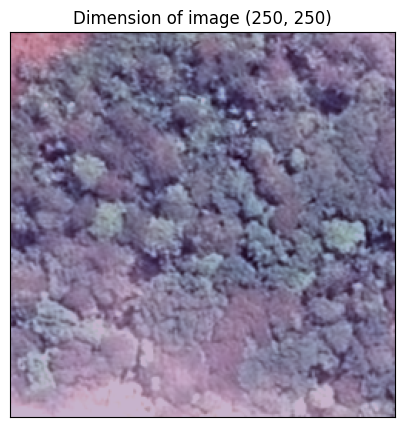

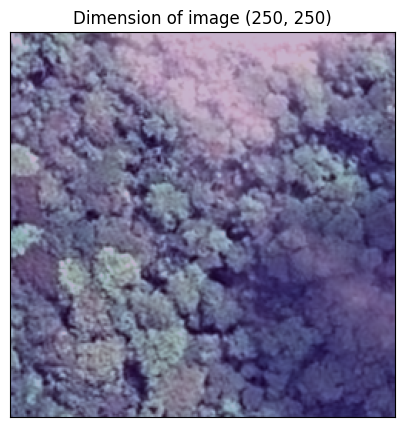

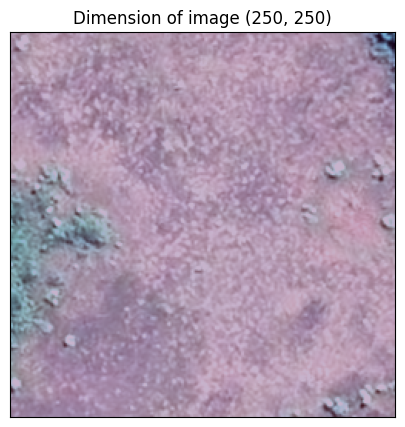

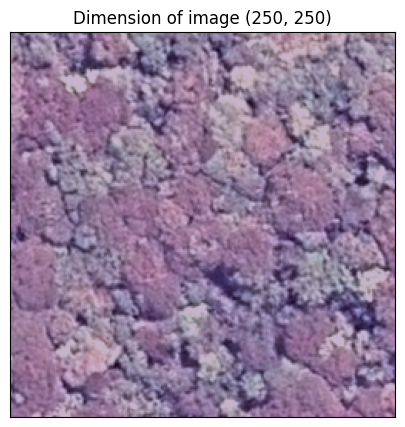

In [134]:
trainer.test(lightning_module, data_module)

In [120]:
#batch = next(iter(data_module.dataset_test))

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)


album.Resize(*image_size, always_apply=True)

satellite_image = SatelliteImage.from_raster(
        file_path = "../splitted_data/images/ORT_2022072050325085_0348_0535_U22N_16Bits_14.tif",
        dep = None,
        date = None,
        n_bands= 3)

test = np.transpose(satellite_image.array,[2,1,0])

print(test.shape)
print(album.Resize(width = 250, height = 250, always_apply=True)(image = test)["image"].shape)


(250, 250, 3)
(250, 250, 3)


In [131]:

from torch.utils.data import DataLoader, Dataset, random_split
dataset_test = PleiadeDataset(list_path_images[30:40],list_path_labels[30:40]) # à changer avec des images bien spécifiques et une fonction préparer test
#dataset_test.transforms = transforms_preprocessing
next(iter(dataset_test))[0].shape


None


/home/onyxia/work/detection-habitat-spontane/notebooks/../src/datas/components/dataset.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([3, 250, 250])

In [56]:
#trainer.test(lightning_module,datamodule = data_module)


val = data_module.val_dataloader()
batch = next(iter(val))
print("youyou")
test = data_module.test_dataloader()
print(test)
batch = next(iter(test))



youyou


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/onyxia/work/detection-habitat-spontane/notebooks/../src/datas/components/dataset.py", line 202, in __getitem__
    sample = self.transforms(image = img, label = label)
  File "/opt/mamba/lib/python3.10/site-packages/albumentations/core/composition.py", line 205, in __call__
    data = t(**data)
  File "/opt/mamba/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 118, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/opt/mamba/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 131, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/opt/mamba/lib/python3.10/site-packages/albumentations/augmentations/transforms.py", line 218, in apply
    return F.normalize(image, self.mean, self.std, self.max_pixel_value)
  File "/opt/mamba/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 97, in normalize
    return normalize_numpy(img, mean, denominator)
  File "/opt/mamba/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 81, in normalize_numpy
    img -= mean
ValueError: operands could not be broadcast together with shapes (250,250,250) (3,) (250,250,250) 


In [ ]:
artifact_uri = mlflow.get_artifact_uri(run_id="466b28daecf24368b6be922dfce775ca3")

artifact_path = artifact_uri + '/my_plot.png'  # Path to the artifact file

# Perform any file I/O operations to display or visualize the artifact
# For example, if using matplotlib, you can use plt.imread() and plt.imshow()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(artifact_path)
imgplot = plt.imshow(img)
plt.show()

### Test du modèle

TO DO :
- faire juste du train-validation, dans la liste de test 
- recupérer les listes de chemin de fichier dans MLFLOW
- dans le validation, produire l'IOU pour le test aussi ? voir MAP indicaztor et autres

**Calcul IOU**

In [69]:
from torch import nn, optim
#nn.CrossEntropyLoss(output,label)
loss = nn.CrossEntropyLoss()
loss(output,label)

tensor(0.6931)

**Retrouver situation à partir du batch**

In [95]:
from utils.labeled_satellite_image import SegmentationLabeledSatelliteImage

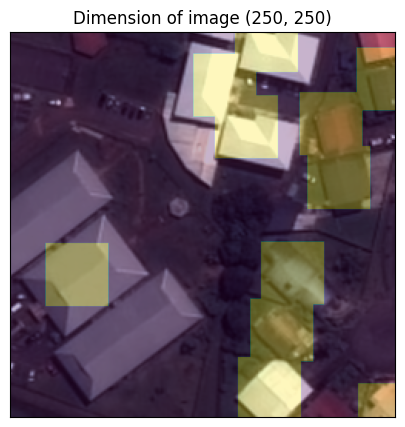

In [98]:
pthimg = dico["pathimage"][2]
pthlabel = dico["pathlabel"][2]

satellite_image = SatelliteImage.from_raster(
        file_path = pthimg,
        dep = None,
        date = None,
        n_bands= 3)


img_label_gt= SegmentationLabeledSatelliteImage(satellite_image,np.load(pthlabel),"MODEL",None)
img_label_model = SegmentationLabeledSatelliteImage(satellite_image,pred[2],"MODEL",None)
#satellite_image.plot([0,1,2])

fig = img_label_gt.plot([0,1,2])
#img_label_model.plot([0,1,2])
fig.savefig("test.png")

In [21]:
predmodel.shape

(250,)

In [ ]:
trainer.test(lightning_module,data_module)

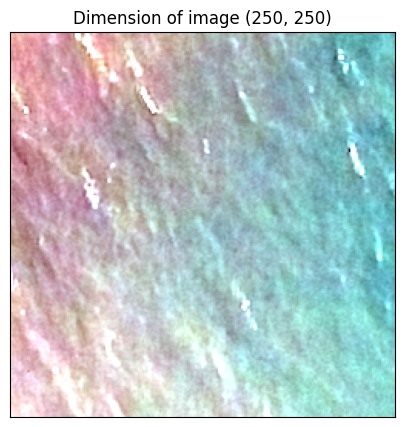

In [95]:
image, label, dico =  data_module.mono_image_dataset.__getitem__(10000)
            
satellite_image = SatelliteImage.from_raster(
        file_path = dico["pathimage"],
        dep = None,
        date = None,
        n_bands= 3)

#satellite_image.array
satellite_image.plot([0,1,2])

## S2Looking training !

dl

In [ ]:
update_storage_access()
environment = get_environment()
root_path = get_root_path()
bucket = environment["bucket"]
path_s3_s2looking = environment["sources"]["PAPERS"]["S2Looking"]
path_local_s2looking = environment["local-path"]["PAPERS"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

fs.download(
        rpath=f"{bucket}/{path_s3_s2looking}",
        lpath=f"../{path_local_s2looking}",
        recursive=True)

In [ ]:
import zipfile
with zipfile.ZipFile(f"../{path_local_s2looking}/S2Looking.zip", 'r') as zip_ref:
    zip_ref.extractall(f"../{path_local_s2looking}")

In [ ]:
#!pip install mlflow
import mlflow

run_name = "s2looking" # config
remote_server_uri = "https://projet-slums-detection-2439.user.lab.sspcloud.fr"
experiment_name = "segmentation" # config

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
# mlflow.pytorch.autolog() # logger la config


## Création Dataset
torch.cuda.empty_cache()
gc.collect()

## En faire une fonction ? : Idée faire une classe de préparation des données pour chaque data set chargé qui in fine sortirait une list path ?

### config, appeler une fionction de création de dataset ?
dir_data = "../data/paper_dataset/S2Looking/"
img1_train = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]
img1_val = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]

img1_train = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]
img1_val = [dir_data + "val/Image1/"+name for name in os.listdir(dir_data + "/val/Image1")]
img1_test = [dir_data + "test/Image1/"+name for name in os.listdir(dir_data + "/test/Image1")]

img2_train = [dir_data + "train/Image2/"+name for name in os.listdir(dir_data + "/train/Image2")]
img2_val = [dir_data + "val/Image2/"+name for name in os.listdir(dir_data + "/val/Image2")]
img2_test = [dir_data + "test/Image2/"+name for name in os.listdir(dir_data + "/test/Image2")]

label_train = [dir_data + "train/label/"+name for name in os.listdir(dir_data + "/train/label")]
label_val = [dir_data + "val/label/"+name for name in os.listdir(dir_data + "/val/label")]
label_test = [dir_data + "test/label/"+name for name in os.listdir(dir_data + "/test/label")]

img1_path = np.concatenate([np.sort(img1_train),np.sort(img1_val),np.sort(img1_test)])
img2_path = np.concatenate([np.sort(img2_train),np.sort(img2_val),np.sort(img2_test)])
label_path = np.concatenate([np.sort(label_train),np.sort(label_val),np.sort(label_test)])

mono_image_dataset = ChangeDetectionS2LookingDataset(img1_path,img2_path,label_path)

# transforms incorporé dans les dataset a posteriori
image_size = (256,256) # cf la classe dataset
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ]
    )

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)


## Instanciation modèle et paramètres d'entraînement

optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module(nchannel = 6) # viens du data set qui concatene 2 images à 3 channels

##Instanciation des datamodule et plmodule

data_module = DataModule(
    mono_image_dataset= mono_image_dataset,
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, 
    batch_size=2
)


lightning_module = SegmentationModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)

checkpoint_callback = ModelCheckpoint(
    monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
)

checkpoint_callback_2 = ModelCheckpoint(
    monitor="train_loss", save_top_k=1, save_last=True, mode="min"
)
early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

strategy ="auto"

with mlflow.start_run(run_name=run_name):

    trainer = pl.Trainer(
    callbacks=[lr_monitor, checkpoint_callback,checkpoint_callback_2, early_stop_callback],
    max_epochs=100,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.fit(lightning_module, datamodule=data_module)
    
    lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                     )
    artifact_path = "models/modele_change_detection_deeplabv3_on_s2_looking"
    mlflow.pytorch.log_model(lightning_module_checkpoint.model, artifact_path)
    
    

2023/04/06 18:30:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | DeepLabv3Module  | 61.0 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
61.0 M    Trainable params
0         Non-trainable params
61.0 M    Total params
244.003   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Evaluer un modèle entrainé sur des exemples du jeu de test et envoyer à MLFLOW

In [ ]:
optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module(nchannel = 6) # viens du data set qui concatene 2 images à 3 channels

strategy  = "auto"

lightning_module_checkpoint = SegmentationModule.load_from_checkpoint(
    checkpoint_path = "lightning_logs/version_10/checkpoints/epoch=15-step=28000.ckpt",
    model= model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                     )


# je prends un dataloader basé sur plusieurs exemples tests bien choisi ?
# faire ça après entraînement d'un modèle de segmentation ce sera plus facile!

### Exporter a posteriori un modèle dans MLFLOW

In [22]:
%env AWS_ACCESS_KEY_ID=projet-slums-sa
%env AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr # chercher ça dans secret ? normalement le update storage access suffit
%env AWS_S3_ENDPOINT=minio.lab.sspcloud.fr
%env MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr # à préciser en +

env: AWS_ACCESS_KEY_ID=projet-slums-sa
env: AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr # chercher ça dans secret ? normalement le update storage access suffit
env: AWS_S3_ENDPOINT=minio.lab.sspcloud.fr
env: MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr # à préciser en +


In [20]:
import mlflow

#update_storage_access()
# Save the trained model to the target run
run_id ="7dc98255e1f14645843d586e4567517d"
# Log additional artifacts to the target run
mlflow.start_run(run_id = run_id)
artifact_path = "models/modele_change_detection_deeplabv3_on_s2_looking"
mlflow.pytorch.log_model(lightning_module_checkpoint.model, artifact_path)
mlflow.end_run()

2023/04/11 12:02:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/04/11 12:02:59 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torchvision==0.15.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


## TO DO

- Trouver des exemples à changements dans Mayotte
- d&égager aussi les RIL vides ?
- test de lancement via invit de comande train
- lancer une entrainement de segmentation et mettre une liste d'image en dur dans la list des paths de dataset
- Créer un premier dico de config qui appellerait la fonction relative au dataset pour le produire et un seul fichier train !
 1) au final le fiochier de config sserait modifé par le lanceur on aurait un seul et unique fchier de train./
- corriger istoo black, ddetection de nuages
- retrouver des patchs où ça bouge via le RIL N N-1
- filtrer les patchs mauvais, avant l'écriture.. ecrire en dur une liste d'images ennuagée
- Modif des codes de Tom : #### 1) modification des codes de Tom pour que son train marche quand même !
- save la liste des paths fichiers test dans MLFLOW ?